In [2]:
import os
import sys

os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [3]:
import pyspark
myConf=pyspark.SparkConf() # SparkSession에 필요한 설정을 삽입해서 만듦. 지금은 공란
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config("spark.sql.warehouse.dir", "C:\users\g312")\
    .getOrCreate()

In [4]:
print spark.version

2.0.0


## DataFrame

In [5]:
myList=[('1','kim, js',170),
        ('1','lee, sm', 175),
        ('2','lim, yg',180),
        ('2','lee',170)]

In [6]:
myDf=spark.createDataFrame(myList) #내부든 외부든 createDataFrame쓰면 DF가 생성됨

In [7]:
myDf.printSchema() #앞 두 column은 string ('')으로, 마지막 column은 long으로 자동 지정
print myDf.take(1) #column이름이 없으므로 열은 _1, _2와 같이 표시됨

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)

[Row(_1=u'1', _2=u'kim, js', _3=170)]


In [8]:
print spark.createDataFrame(myList, ['year','name','height']).take(1)
#이와 같이 열의 이름을 설정하면 출력시에도 열의 이름으로 보여준다.

[Row(year=u'1', name=u'kim, js', height=170)]


In [9]:
names = ["kim","lee","lee","lim"]
items = ["espresso","latte","americano","affocato","long black","macciato"]
df = spark.createDataFrame([(names[i%4], items[i%6]) for i in range(100)],\
                           ["name","item"])
#위에 있는 이름과 아이템들을 순서대로 100번 반복반환한다.
#names[i%4], items[i%6] i->0, 1, 2, 3 and i->0, 1, 2, 3, 4, 5
df.show(10)

+----+----------+
|name|      item|
+----+----------+
| kim|  espresso|
| lee|     latte|
| lee| americano|
| lim|  affocato|
| kim|long black|
| lee|  macciato|
| lee|  espresso|
| lim|     latte|
| kim| americano|
| lee|  affocato|
+----+----------+
only showing top 10 rows



In [10]:
df.select(df.item.substr(1, 3).alias("short name")).show(3)
#substr -> 선택할 문자의 range(현재는 세글자), alias -> 컬럼의 이름

+----------+
|short name|
+----------+
|       esp|
|       lat|
|       ame|
+----------+
only showing top 3 rows



In [11]:
from pyspark.sql import Row # Row 객체를 사용한다.
Person = Row('year','name', 'height') #Row안(속성)에는 column의 이름이 들어감.
row1=Person('1','kim, js',170)#Person이란 Row 객체에 맞춰 행을 입력.

In [12]:
print "row1: ", row1.year, row1.name #row.key 방식으로 출력, row[key]로도 출력된다.

row1:  1 kim, js


In [13]:
myRows = [row1, #myRows(DataFrame)에 들어갈 객체로 만들어진 객체를 넣을 수 있다.
          Person('1','lee, sm', 175),
          Person('2','lim, yg',180),
          Person('2','lee',170)] 
#DataFrame을 List의 형태로 생성하는 방식

In [14]:
myDf=spark.createDataFrame(myRows)

In [15]:
print myDf.printSchema()
myDf.show()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: long (nullable = true)

None
+----+-------+------+
|year|   name|height|
+----+-------+------+
|   1|kim, js|   170|
|   1|lee, sm|   175|
|   2|lim, yg|   180|
|   2|    lee|   170|
+----+-------+------+



In [16]:
#Schema를 정의해보자.
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType
mySchema=StructType([
    StructField("year", StringType(), True),
    StructField("name", StringType(), True),
    StructField("height", IntegerType(), True)
])
#현재 StructField엔 column의 명칭, 타입, 그리고 Null의 허용여부가 순서대로 입력되어 있다


In [17]:
myDf=spark.createDataFrame(myRows, mySchema) #처음과 다르게 리스트와 스키마를 같이 부름.
myDf.printSchema() #결과에서 보이듯이 자동지정된 Long이 아닌 Int형이다.
myDf.take(1) 

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)



[Row(year=u'1', name=u'kim, js', height=170)]

In [18]:
#Rdd로 DF를 생성해보자.
from pyspark.sql import Row

myList=[('1','kim, js',170),('1','lee, sm', 175),('2','lim, yg',180),('2','lee',170)]
myRdd = spark.sparkContext.parallelize(myList)

In [19]:
rddDf=myRdd.toDF() #toDF 함수로 RDD가 DF로 형변환된다. Schema가 없으므로 자동지정됨.
rddDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



In [20]:
rddDf=spark.createDataFrame(myRdd) #RDD를 생성함수로도 변환시킬 수 있다.
rddDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



In [21]:
rddDf.where(rddDf._3 < 175)\
    .select([rddDf._1, rddDf._2])\
    .show() 
#데이터에서 _3(세번째 column)의 value<175인 row는?
#1, 2번 column을 선택
#선택된 column과 row만 보여준다.

+---+-------+
| _1|     _2|
+---+-------+
|  1|kim, js|
|  2|    lee|
+---+-------+



In [22]:
rddDf.groupby(rddDf._1).max().show()
#이거 어려워 보이는데 쉬움.
#일단 DF를 rddDf._1(key)로 그룹핑하고 그룹마다의 value의 최댓값을 골라 이를 출력한다. 

+---+-------+
| _1|max(_3)|
+---+-------+
|  1|    175|
|  2|    180|
+---+-------+



In [23]:
#Row 객체로 위를 구현해보자.
_myRdd=myRdd.map(lambda x:Row(year=int(x[0]),name=x[1],height=int(x[2])))
#year는 int로 자동 형변환된다.
#맵에서 column이름을 정해준다.
#RDD에서도 Row 객체를 쓸 수 있구나.

In [24]:
_myDf=spark.createDataFrame(_myRdd) # 위와 같은 과정
_myDf.printSchema() #위에선 int로 받았지만, schema 설정한 것은 아니므로 자동지정
_myDf.take(1)

root
 |-- height: long (nullable = true)
 |-- name: string (nullable = true)
 |-- year: long (nullable = true)



[Row(height=170, name=u'kim, js', year=1)]

In [25]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType, TimestampType
r1=Row(name="js1",age=10)
r2=Row(name="js2",age=20)
_myRdd=spark.sparkContext.parallelize([r1,r2])
#Row 객체로 RDD를 생성할 수 있는 것이었다.

In [26]:
_myRdd.collect()

[Row(age=10, name='js1'), Row(age=20, name='js2')]

In [27]:
#createDataFrame함수에 (Rdd, schema)로 정의한 schema를 생성할 수 있다.
schema=StructType([
    StructField("age", IntegerType(), True),
    StructField("name", StringType(), True),
    #StructField("created", TimestampType(), True)
])
_myDf=spark.createDataFrame(_myRdd,schema)
_myDf.printSchema()
_myDf.show()

root
 |-- age: integer (nullable = true)
 |-- name: string (nullable = true)

+---+----+
|age|name|
+---+----+
| 10| js1|
| 20| js2|
+---+----+



In [28]:
#위의 RDD->DF + Schema를 정리하면 아래와 같다.

from pyspark.sql.types import *
myRdd=spark.sparkContext.parallelize([(1, 'kim', 50.0), (2, 'lee', 60.0), (3, 'park', 70.0)])
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("height", DoubleType(), True)
])
_myDf = spark.createDataFrame(myRdd, schema)
_myDf.printSchema()
_myDf.show()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: double (nullable = true)

+---+----+------+
| id|name|height|
+---+----+------+
|  1| kim|  50.0|
|  2| lee|  60.0|
|  3|park|  70.0|
+---+----+------+



## Pandas

In [29]:
myDf.toPandas()

,year,name,height
0,1,"kim, js",170
1,1,"lee, sm",175
2,2,"lim, yg",180
3,2,lee,170


In [30]:
#myDf.write.format('com.databricks.spark.csv').save(os.path.join('data','_myDf.csv')) #error 발생.

In [31]:
#!doskey ls = dir #doskey ls란 이름으로 dir 기능을 구현

In [32]:
%%writefile data\ds_twitter_seoul_3.json
{"contributors": null, "truncated": false, "text": "RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fi…", "is_quote_status": false, "in_reply_to_status_id": null, "id": 801657325836763136, "favorite_count": 0, "entities": {"symbols": [], "user_mentions": [{"id": 17659206, "indices": [3, 10], "id_str": "17659206", "screen_name": "soompi", "name": "Soompi"}], "hashtags": [{"indices": [12, 22], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [100, 123], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev…"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "id_str": "801657325836763136", "favorited": false, "retweeted_status": {"contributors": null, "truncated": false, "text": "#SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fifXHpF8or", "is_quote_status": false, "in_reply_to_status_id": null, "id": 800593781586132993, "favorite_count": 1649, "entities": {"symbols": [], "user_mentions": [], "hashtags": [{"indices": [0, 10], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [88, 111], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev…"}], "media": [{"expanded_url": "https://twitter.com/soompi/status/800593781586132993/photo/1", "display_url": "pic.twitter.com/fifXHpF8or", "url": "https://t.co/fifXHpF8or", "media_url_https": "https://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg", "id_str": "800593115165798400", "sizes": {"small": {"h": 382, "resize": "fit", "w": 680}, "large": {"h": 449, "resize": "fit", "w": 800}, "medium": {"h": 449, "resize": "fit", "w": 800}, "thumb": {"h": 150, "resize": "crop", "w": 150}}, "indices": [112, 135], "type": "photo", "id": 800593115165798400, "media_url": "http://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\"https://about.twitter.com/products/tweetdeck\" rel=\"nofollow\">TweetDeck</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "id_str": "800593781586132993", "favorited": false, "user": {"follow_request_sent": false, "has_extended_profile": true, "profile_use_background_image": true, "default_profile_image": false, "id": 17659206, "profile_background_image_url_https": "https://pbs.twimg.com/profile_background_images/699864769/1cdde0a85f5c0a994ae1fb06d545a5ec.png", "verified": true, "translator_type": "none", "profile_text_color": "999999", "profile_image_url_https": "https://pbs.twimg.com/profile_images/792117259489583104/4khJk3zz_normal.jpg", "profile_sidebar_fill_color": "000000", "entities": {"url": {"urls": [{"url": "http://t.co/3evT80UlR9", "indices": [0, 22], "expanded_url": "http://www.soompi.com", "display_url": "soompi.com"}]}, "description": {"urls": []}}, "followers_count": 987867, "profile_sidebar_border_color": "000000", "id_str": "17659206", "profile_background_color": "1E1E1E", "listed_count": 3982, "is_translation_enabled": true, "utc_offset": -28800, "statuses_count": 80038, "description": "The original K-pop community. We take gifs, OTPs, and reporting on your bias' fashion choices seriously. But not rumors. Ain't nobody got time for that.", "friends_count": 3532, "location": "Worldwide", "profile_link_color": "31B6F4", "profile_image_url": "http://pbs.twimg.com/profile_images/792117259489583104/4khJk3zz_normal.jpg", "following": false, "geo_enabled": false, "profile_banner_url": "https://pbs.twimg.com/profile_banners/17659206/1478803767", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/699864769/1cdde0a85f5c0a994ae1fb06d545a5ec.png", "screen_name": "soompi", "lang": "en", "profile_background_tile": true, "favourites_count": 1493, "name": "Soompi", "notifications": false, "url": "http://t.co/3evT80UlR9", "created_at": "Wed Nov 26 20:48:27 +0000 2008", "contributors_enabled": false, "time_zone": "Pacific Time (US & Canada)", "protected": false, "default_profile": false, "is_translator": false}, "geo": null, "in_reply_to_user_id_str": null, "possibly_sensitive": false, "lang": "en", "created_at": "Mon Nov 21 06:56:46 +0000 2016", "in_reply_to_status_id_str": null, "place": null, "extended_entities": {"media": [{"expanded_url": "https://twitter.com/soompi/status/800593781586132993/photo/1", "display_url": "pic.twitter.com/fifXHpF8or", "url": "https://t.co/fifXHpF8or", "media_url_https": "https://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg", "id_str": "800593115165798400", "sizes": {"small": {"h": 382, "resize": "fit", "w": 680}, "large": {"h": 449, "resize": "fit", "w": 800}, "medium": {"h": 449, "resize": "fit", "w": 800}, "thumb": {"h": 150, "resize": "crop", "w": 150}}, "indices": [112, 135], "type": "photo", "id": 800593115165798400, "media_url": "http://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg"}]}, "metadata": {"iso_language_code": "en", "result_type": "recent"}}, "user": {"follow_request_sent": false, "has_extended_profile": false, "profile_use_background_image": true, "default_profile_image": true, "id": 791090169818521600, "profile_background_image_url_https": null, "verified": false, "translator_type": "none", "profile_text_color": "333333", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_6_normal.png", "profile_sidebar_fill_color": "DDEEF6", "entities": {"description": {"urls": []}}, "followers_count": 0, "profile_sidebar_border_color": "C0DEED", "id_str": "791090169818521600", "profile_background_color": "F5F8FA", "listed_count": 0, "is_translation_enabled": false, "utc_offset": null, "statuses_count": 96, "description": "", "friends_count": 7, "location": "", "profile_link_color": "1DA1F2", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_6_normal.png", "following": false, "geo_enabled": false, "profile_background_image_url": null, "screen_name": "enriquesanq", "lang": "es", "profile_background_tile": false, "favourites_count": 161, "name": "Enrique santos", "notifications": false, "url": null, "created_at": "Wed Oct 26 01:32:49 +0000 2016", "contributors_enabled": false, "time_zone": null, "protected": false, "default_profile": true, "is_translator": false}, "geo": null, "in_reply_to_user_id_str": null, "possibly_sensitive": false, "lang": "en", "created_at": "Thu Nov 24 05:22:55 +0000 2016", "in_reply_to_status_id_str": null, "place": null, "metadata": {"iso_language_code": "en", "result_type": "recent"}}


Overwriting data\ds_twitter_seoul_3.json


In [33]:
import os
_jfname=os.path.join('data','ds_twitter_seoul_3.json')
with open(_jfname, 'rb') as f:
    data = f.readlines()
    
data

['{"contributors": null, "truncated": false, "text": "RT @soompi: #SEVENTEEN\xe2\x80\x99s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \\nhttps://t.co/1XRSaRBbE0 https://t.co/fi\xe2\x80\xa6", "is_quote_status": false, "in_reply_to_status_id": null, "id": 801657325836763136, "favorite_count": 0, "entities": {"symbols": [], "user_mentions": [{"id": 17659206, "indices": [3, 10], "id_str": "17659206", "screen_name": "soompi", "name": "Soompi"}], "hashtags": [{"indices": [12, 22], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [100, 123], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev\xe2\x80\xa6"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\\"http://twitter.com/download/android\\" rel=\\"nofollow\\">Twitter for Android</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "

In [34]:
data = map(lambda x: x.rstrip(), data)

In [35]:
print "+".join(["A", "B", "C"]) #join 함수는 앞의 문자와 안의 인자를 결합

data_json_str = "[" + ','.join(data) + "]"

A+B+C


In [36]:
len(data_json_str)

6908

In [37]:
import pandas as pd

data_df = pd.read_json(data_json_str)

In [38]:
print data_df.count() #행의 개수  #전자는 column명이다.

contributors                 0
coordinates                  0
created_at                   1
entities                     1
favorite_count               1
favorited                    1
geo                          0
id                           1
id_str                       1
in_reply_to_screen_name      0
in_reply_to_status_id        0
in_reply_to_status_id_str    0
in_reply_to_user_id          0
in_reply_to_user_id_str      0
is_quote_status              1
lang                         1
metadata                     1
place                        0
possibly_sensitive           1
retweet_count                1
retweeted                    1
retweeted_status             1
source                       1
text                         1
truncated                    1
user                         1
dtype: int64


In [39]:
data_df['id'][:10]

0    801657325836763136
Name: id, dtype: int64

In [40]:
import numpy as np
np.array

<function numpy.array>

In [41]:
from pyspark.sql.types import *
rdd=spark.sparkContext\
    .textFile(os.path.join('data','ds_spark_heightweight.txt'))

tRdd=rdd.map(lambda x:x.split('\t'))
tDf=spark.createDataFrame(tRdd)

tDf.printSchema()

tDf.take(1)

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)



[Row(_1=u'1', _2=u'65.78', _3=u'112.99')]

In [42]:
tDf=tDf.withColumn("id",tDf['_1'].cast("integer")).drop('_1')
tDf=tDf.withColumn("height",tDf['_2'].cast("double")).drop('_2')
tDf=tDf.withColumn("weight",tDf['_3'].cast("double")).drop('_3')

tDf.take(1)

[Row(id=1, height=65.78, weight=112.99)]

In [43]:
tRdd=rdd.map(lambda line:[float(x) for x in line.split('\t')])
tRdd.take(1)

tDf=spark.createDataFrame(tRdd,["id","weight","height"])

tDf.printSchema()
tDf.take(1)

root
 |-- id: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)



[Row(id=1.0, weight=65.78, height=112.99)]

[65.78 71.52 69.4  68.22 67.79]
[112.99 136.49 153.03 142.34 144.3 ]


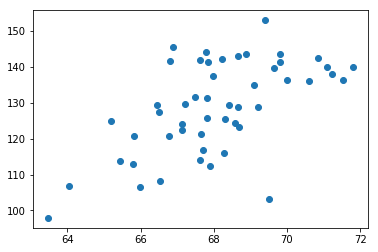

In [44]:
import numpy as np
_weightRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
_heightRdd=tDf.rdd.map(lambda fields:fields[2]).collect()
print np.array(_weightRdd)[:5]
print np.array(_heightRdd)[:5]

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(_weightRdd), np.array(_heightRdd),'o')
plt.show()

#년별 분기별 대여건수

In [53]:
_bicycle = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/bicycle.csv')

In [54]:
_bicycle.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- count: integer (nullable = true)



In [55]:
_bicycle.count()

455

In [56]:
_bicycle.show(5)

+--------------------+-----+
|                date|count|
+--------------------+-----+
|2018-01-01 00:00:...| 4950|
|2018-01-02 00:00:...| 7136|
|2018-01-03 00:00:...| 7156|
|2018-01-04 00:00:...| 7102|
|2018-01-05 00:00:...| 7705|
+--------------------+-----+
only showing top 5 rows



In [57]:
bicycle=_bicycle\
    .withColumnRenamed("date", "Date")\
    .withColumnRenamed(" count", "Count")

In [58]:
bicycle.show(5)

+--------------------+-----+
|                Date|count|
+--------------------+-----+
|2018-01-01 00:00:...| 4950|
|2018-01-02 00:00:...| 7136|
|2018-01-03 00:00:...| 7156|
|2018-01-04 00:00:...| 7102|
|2018-01-05 00:00:...| 7705|
+--------------------+-----+
only showing top 5 rows



In [60]:
bicycle=bicycle.withColumn("year",bicycle.Date.substr(1, 4))
bicycle=bicycle.withColumn("month",bicycle.Date.substr(6, 2))

In [61]:
import pyspark.sql.functions as F
bicycle = bicycle\
    .withColumn('year', F.year('date'))\
    .withColumn('month', F.month('date'))

In [62]:
bicycle.groupBy('year').agg({"count":"sum"}).show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



In [63]:
bicycle.groupBy('year').pivot('month').agg({"count":"sum"}).show()

+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|year|     1|     2|     3|     4|     5|      6|      7|      8|      9|     10|    11|    12|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|2018|164367|168741|462661|687885|965609|1207123|1100015|1037505|1447993|1420621|961532|500822|
|2019|495573|471543|904819|  null|  null|   null|   null|   null|   null|   null|  null|  null|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+



In [ ]:
#Json 파일 읽기

In [64]:
#C:\Users\G312\Downloads\spark-2.0.0-bin-hadoop2.7\examples\src\main\resources에서 people.json을 추출
jfile= os.path.join(os.environ["SPARK_HOME"],\
           "examples/src/main/resources/people.json")

_myDf= spark.read.json(jfile)

In [66]:
_myDf.filter(_myDf['age'] > 21).show()

+---+----+
|age|name|
+---+----+
| 30|Andy|
+---+----+



In [67]:
import requests
r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()

In [68]:
print type(wc), type(wc[0])

<type 'list'> <type 'dict'>


In [69]:
wc[0] # dictionary의 리스트로 구성되어 있어 dictionary(중괄호)가 하나의 단위

{u'Club': u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada',
 u'ClubCountry': u'Argentina',
 u'Competition': u'World Cup',
 u'DateOfBirth': u'1905-5-5',
 u'FullName': u'\xc3ngel Bossio',
 u'IsCaptain': False,
 u'Number': u'',
 u'Position': u'GK',
 u'Team': u'Argentina',
 u'Year': 1930}

In [71]:
## 웹데이터는 항상 '문자' 취급 해야 한다.
## 또한 데이터를 수집하고 불러올 때 '통계적'으로 생각해보자
## 국가별로 몇 명있지? 성씨 같은 사람이 몇 명이나 있지?
wcDF=spark.createDataFrame(wc)
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



In [72]:
wcDF.take(1)

[Row(Club=u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada', ClubCountry=u'Argentina', Competition=u'World Cup', DateOfBirth=u'1905-5-5', FullName=u'\xc3ngel Bossio', IsCaptain=False, Number=u'', Position=u'GK', Team=u'Argentina', Year=1930)]

In [73]:
#dateType 형변환
from datetime import datetime
print datetime.strptime("11/25/1991", '%m/%d/%Y')

1991-11-25 00:00:00


In [83]:
from pyspark.sql.functions import udf
toDate = udf(lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

wcDF = wcDF.withColumn('date1', toDate(wcDF['DateOfBirth']))
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- date2: date (nullable = true)
 |-- date3: date (nullable = true)
 |-- NumberInt: integer (nullable = true)
 |-- date1: date (nullable = true)



In [84]:
from pyspark.sql.functions import to_date

wcDF=wcDF.withColumn('date2', to_date(wcDF['DateOfBirth']))

#to_date는 위의 datetime보다 쉬운 방법이다.

In [85]:
from pyspark.sql.types import DateType

wcDF=wcDF.withColumn('date3', wcDF['DateOfBirth'].cast(DateType()))
wcDF=wcDF.withColumn('NumberInt', wcDF['Number'].cast("integer"))

wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- date2: date (nullable = true)
 |-- date3: date (nullable = true)
 |-- NumberInt: integer (nullable = true)
 |-- date1: date (nullable = true)



In [86]:
wcDF=wcDF.drop('date1')

In [87]:
wcDF.take(1)

[Row(Club=u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada', ClubCountry=u'Argentina', Competition=u'World Cup', DateOfBirth=u'1905-5-5', FullName=u'\xc3ngel Bossio', IsCaptain=False, Number=u'', Position=u'GK', Team=u'Argentina', Year=1930, date2=datetime.date(1905, 5, 5), date3=datetime.date(1905, 5, 5), NumberInt=None)]

In [88]:
wcDF.groupBy(wcDF.ClubCountry).count().show()

+-----------+-----+
|ClubCountry|count|
+-----------+-----+
|   England |    4|
|   Paraguay|   93|
|     Russia|   51|
|        POL|   11|
|        BRA|   27|
|    Senegal|    1|
|     Sweden|  154|
|   Colombia|    1|
|        FRA|  155|
|        ALG|    8|
|   England |    1|
|       RUS |    1|
|     Turkey|   65|
|      Zaire|   22|
|       Iraq|   22|
|    Germany|  206|
|        RSA|   16|
|        ITA|  224|
|        UKR|   38|
|        GHA|    8|
+-----------+-----+
only showing top 20 rows



In [89]:
wcDF.groupBy('ClubCountry').pivot('Position').count().show()
#pivot() 험수 안의 인자는 컬럼 명이 들어간다.

+-----------+----+----+----+----+----+
|ClubCountry|    |  DF|  FW|  GK|  MF|
+-----------+----+----+----+----+----+
|   England |null|null|   2|null|   2|
|   Paraguay|null|  26|  37|  10|  20|
|     Russia|null|  20|  11|   4|  16|
|        POL|null|   2|   2|   3|   4|
|        BRA|null|   7|   5|   4|  11|
|    Senegal|null|null|null|   1|null|
|     Sweden|null|  40|  47|  25|  42|
|   Colombia|null|null|   1|null|null|
|        ALG|null|   2|null|   6|null|
|        FRA|null|  46|  41|  18|  50|
|   England |null|null|null|null|   1|
|       RUS |null|null|null|   1|null|
|     Turkey|null|  20|  13|  12|  20|
|      Zaire|null|   6|   5|   3|   8|
|       Iraq|null|   6|   4|   3|   9|
|    Germany|null|  64|  51|  16|  75|
|        RSA|null|   5|   2|   3|   6|
|        UKR|null|  13|   7|   4|  14|
|        ITA|null|  74|  42|  19|  89|
|        CMR|null|   1|   1|   1|null|
+-----------+----+----+----+----+----+
only showing top 20 rows



In [96]:
myDf = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/myDf.csv')

myDf.printSchema()
myDf.show()

root
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)

+----+-------+------+
|year|   name|height|
+----+-------+------+
|   1|kim, js|   170|
|   1|lee, sm|   175|
|   2|lim, yg|   180|
|   2|    lee|   170|
+----+-------+------+



In [97]:
wcDF=wcDF.withColumnRenamed('ClubCountry','ClubNation') # 컬럼 네임 변경
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubNation: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- date2: date (nullable = true)
 |-- date3: date (nullable = true)
 |-- NumberInt: integer (nullable = true)



In [98]:
myDf.name

Column<name>

In [99]:
myDf['name']

Column<name>

In [100]:
_name=myDf.select('name')
_name.collect()

[Row(name=u'kim, js'),
 Row(name=u'lee, sm'),
 Row(name=u'lim, yg'),
 Row(name=u'lee')]

In [102]:
r=Row(name=u'kim, js')
rd=r.asDict()
print rd.values()[0].split(',')

[u'kim', u' js']


In [103]:
myDf.where(myDf['height'] < 175)\
    .select(myDf['name'], myDf['height']).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|    lee|   170|
+-------+------+



In [105]:
myDf.groupby(myDf['year']).max().show()

+----+---------+-----------+
|year|max(year)|max(height)|
+----+---------+-----------+
|   1|        1|        175|
|   2|        2|        180|
+----+---------+-----------+



In [106]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
#udf는 사용자 정의 함수. 함수를 만들어 쓸 수 있다.
toDoublefunc = udf(lambda x: float(x),DoubleType())
myDf = myDf.withColumn("heightD",toDoublefunc(myDf.height))

myDf.printSchema()

root
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- heightD: double (nullable = true)



In [107]:
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import IntegerType
toint=udf(lambda x:int(x),IntegerType())
myDf=myDf.withColumn("yearI",toint(myDf['year']))

In [108]:
myDf.printSchema()
myDf.show()

root
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- heightD: double (nullable = true)
 |-- yearI: integer (nullable = true)

+----+-------+------+-------+-----+
|year|   name|height|heightD|yearI|
+----+-------+------+-------+-----+
|   1|kim, js|   170|  170.0|    1|
|   1|lee, sm|   175|  175.0|    1|
|   2|lim, yg|   180|  180.0|    2|
|   2|    lee|   170|  170.0|    2|
+----+-------+------+-------+-----+



In [109]:
myDf.select('yearI').show()

+-----+
|yearI|
+-----+
|    1|
|    1|
|    2|
|    2|
+-----+



In [110]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
 
def uppercase(s):
    return s.upper()

upperUdf = udf(uppercase, StringType())
myDf = myDf.withColumn("nameUpper", upperUdf(myDf['name']))
myDf.show()

+----+-------+------+-------+-----+---------+
|year|   name|height|heightD|yearI|nameUpper|
+----+-------+------+-------+-----+---------+
|   1|kim, js|   170|  170.0|    1|  KIM, JS|
|   1|lee, sm|   175|  175.0|    1|  LEE, SM|
|   2|lim, yg|   180|  180.0|    2|  LIM, YG|
|   2|    lee|   170|  170.0|    2|      LEE|
+----+-------+------+-------+-----+---------+



In [111]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
#키를 Boolean(이진법)으로 나누어보자
height_udf = udf(lambda height: "taller" if height >=175 else "shorter", StringType())
heightDf=myDf.withColumn("height>175", height_udf(myDf.heightD))
heightDf.show()

+----+-------+------+-------+-----+---------+----------+
|year|   name|height|heightD|yearI|nameUpper|height>175|
+----+-------+------+-------+-----+---------+----------+
|   1|kim, js|   170|  170.0|    1|  KIM, JS|   shorter|
|   1|lee, sm|   175|  175.0|    1|  LEE, SM|    taller|
|   2|lim, yg|   180|  180.0|    2|  LIM, YG|    taller|
|   2|    lee|   170|  170.0|    2|      LEE|   shorter|
+----+-------+------+-------+-----+---------+----------+



In [113]:
height = 100
"taller" if height >=175 else "shorter"

'shorter'

In [114]:
myDf.describe().show() #describe를 쓰면 요약 값을 볼 수 있다.

+-------+------------------+------------------+------------------+------------------+
|summary|              year|            height|           heightD|             yearI|
+-------+------------------+------------------+------------------+------------------+
|  count|                 4|                 4|                 4|                 4|
|   mean|               1.5|            173.75|            173.75|               1.5|
| stddev|0.5773502691896257|4.7871355387816905|4.7871355387816905|0.5773502691896257|
|    min|                 1|               170|             170.0|                 1|
|    max|                 2|               180|             180.0|                 2|
+-------+------------------+------------------+------------------+------------------+



#SPARK SQL

In [115]:
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubNation: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- date2: date (nullable = true)
 |-- date3: date (nullable = true)
 |-- NumberInt: integer (nullable = true)



In [116]:
wcDF.createOrReplaceTempView("wc") # 테이블이 있으면 불러오고 없으면 보여줘
spark.sql("select Club,Team,Year from wc").show(1)

+--------------------+---------+----+
|                Club|     Team|Year|
+--------------------+---------+----+
|Club AtlÃ©tico Ta...|Argentina|1930|
+--------------------+---------+----+
only showing top 1 row



In [117]:
wcPlayers=spark.sql("select FullName,Club,Team,Year from wc")
wcPlayers.show(1) #SQL 쓸줄 알면 이렇게 쓰는게 좋을듯

+------------+--------------------+---------+----+
|    FullName|                Club|     Team|Year|
+------------+--------------------+---------+----+
|Ãngel Bossio|Club AtlÃ©tico Ta...|Argentina|1930|
+------------+--------------------+---------+----+
only showing top 1 row



In [118]:
spark.catalog.listTables()

[Table(name=u'wc', database=None, description=None, tableType=u'TEMPORARY', isTemporary=True)]

In [119]:
namesRdd=wcPlayers.rdd.map(lambda x: "Full name: "+x[0]) #x[0] : name
for e in namesRdd.take(5):
    print e

Full name: Ãngel Bossio
Full name: Juan Botasso
Full name: Roberto Cherro
Full name: Alberto Chividini
Full name: 


In [120]:
#sql functions

bucketDf=spark.createDataFrame([[1,["orange", "apple", "pineapple"]],
                                [2,["watermelon","apple","bananas"]]],
                               ["bucketId","items"])

bucketDf.show(truncate=False)

+--------+----------------------------+
|bucketId|items                       |
+--------+----------------------------+
|1       |[orange, apple, pineapple]  |
|2       |[watermelon, apple, bananas]|
+--------+----------------------------+



In [122]:
from pyspark.sql.functions import explode
bDf=bucketDf.select(bucketDf.bucketId,explode(bucketDf.items).alias('item'))
#item 내부를 쪼갠다
bDf.show()

+--------+----------+
|bucketId|      item|
+--------+----------+
|       1|    orange|
|       1|     apple|
|       1| pineapple|
|       2|watermelon|
|       2|     apple|
|       2|   bananas|
+--------+----------+



In [124]:
fDf=spark.createDataFrame([["orange", "F1"],
                            ["", "F2"],
                            ["pineapple","F3"],
                            ["watermelon","F4"],
                            ["bananas","F5"]],
                            ["item","itemId"])

fDf.show()

+----------+------+
|      item|itemId|
+----------+------+
|    orange|    F1|
|          |    F2|
| pineapple|    F3|
|watermelon|    F4|
|   bananas|    F5|
+----------+------+



In [125]:
joinDf=fDf.join(bDf, fDf.item==bDf.item, "inner")
#join은 테이블을 연결한다.
#join을 쓰면 기준에 일치하지 않는 데이터를 제외한다.
joinDf.select(fDf.itemId,fDf.item,bDf.bucketId).show()

+------+----------+--------+
|itemId|      item|bucketId|
+------+----------+--------+
|    F5|   bananas|       2|
|    F1|    orange|       1|
|    F3| pineapple|       1|
|    F4|watermelon|       2|
+------+----------+--------+



In [127]:
myDf.show()

from pyspark.sql.functions import when
_myDf=myDf.select(when(myDf['heightD'] >175.0, ">175")\
            .otherwise("<175").alias("how tall"))
_myDf.show()

myDf.groupBy('year').agg({"heightD":"avg"}).show()
#agg ->합계 함수(avg, sum, max, min, count)

+----+-------+------+-------+-----+---------+
|year|   name|height|heightD|yearI|nameUpper|
+----+-------+------+-------+-----+---------+
|   1|kim, js|   170|  170.0|    1|  KIM, JS|
|   1|lee, sm|   175|  175.0|    1|  LEE, SM|
|   2|lim, yg|   180|  180.0|    2|  LIM, YG|
|   2|    lee|   170|  170.0|    2|      LEE|
+----+-------+------+-------+-----+---------+

+--------+
|how tall|
+--------+
|    <175|
|    <175|
|    >175|
|    <175|
+--------+

+----+------------+
|year|avg(heightD)|
+----+------------+
|   1|       172.5|
|   2|       175.0|
+----+------------+



In [128]:
from pyspark.sql import functions as F

myDf.agg(F.min(myDf.heightD),F.max(myDf.heightD),F.avg(myDf.heightD),F.sum(myDf.heightD)).show()
#sql 함수 별도 사용

+------------+------------+------------+------------+
|min(heightD)|max(heightD)|avg(heightD)|sum(heightD)|
+------------+------------+------------+------------+
|       170.0|       180.0|      173.75|       695.0|
+------------+------------+------------+------------+



#과제 네트워크 침입 분석
#데이터 입력 -> attack/un-attack 분류

In [134]:
import os
import urllib
_rdd = spark.sparkContext\
    .textFile(os.path.join('data', 'kddcup.data.gz'))

In [135]:
_rdd.take(10)

[u'0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2,2,1.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3,3,1.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.00,0.00,0.00,0.00,1.00,0.00,0.00,4,4,1.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,238,1282,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,4,0.00,0.00,0.00,0.00,1.00,0.00,0.00,5,5,1.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00,normal.',
 u'0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.00,0.00,0.00,0.00,1.00,0.00,0.

In [136]:
_rdd.count()

4898431

In [137]:
_allRdd=_rdd.map(lambda x:x.split(','))
print _allRdd.take(1)

[[u'0', u'tcp', u'http', u'SF', u'215', u'45076', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'1', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'0', u'0', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']]


In [142]:
 #41번째에 침입의 종류 나와있다 -> 침입의 종류를 키로 하고 Value를 1로(count용)
_fO.reduceByKey(lambda x, y : x+y).collect() #reduceByKey를 써서 Key별로 바로 count 가능

[(u'guess_passwd.', 53),
 (u'nmap.', 2316),
 (u'warezmaster.', 20),
 (u'rootkit.', 10),
 (u'warezclient.', 1020),
 (u'smurf.', 2807886),
 (u'pod.', 264),
 (u'neptune.', 1072017),
 (u'normal.', 972781),
 (u'spy.', 2),
 (u'ftp_write.', 8),
 (u'phf.', 4),
 (u'portsweep.', 10413),
 (u'teardrop.', 979),
 (u'buffer_overflow.', 30),
 (u'land.', 21),
 (u'imap.', 12),
 (u'loadmodule.', 9),
 (u'perl.', 3),
 (u'multihop.', 7),
 (u'back.', 2203),
 (u'ipsweep.', 12481),
 (u'satan.', 15892)]

In [143]:
_normal=_allRdd.filter(lambda x:x[41]=="normal.")
_attack=_allRdd.filter(lambda x:x[41]!="normal.")

print _normal.count()
print _attack.count()

972781
3925650


In [146]:
from pyspark.sql import Row

_csv = _rdd.map(lambda l:l.split(","))
_csvRdd = _csv.map(lambda p:
    Row(
        duration = int(p[0]),
        protocol = p[1],
        service = p[2],
        flag = p[3],
        src_bytes=int(p[4]),
        dst_bytes=int(p[5]),
        attack=p[41]
    )
)

_df =spark.createDataFrame(_csvRdd)
_df.printSchema()
_df.show(5)

root
 |-- attack: string (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- duration: long (nullable = true)
 |-- flag: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- service: string (nullable = true)
 |-- src_bytes: long (nullable = true)

+-------+---------+--------+----+--------+-------+---------+
| attack|dst_bytes|duration|flag|protocol|service|src_bytes|
+-------+---------+--------+----+--------+-------+---------+
|normal.|    45076|       0|  SF|     tcp|   http|      215|
|normal.|     4528|       0|  SF|     tcp|   http|      162|
|normal.|     1228|       0|  SF|     tcp|   http|      236|
|normal.|     2032|       0|  SF|     tcp|   http|      233|
|normal.|      486|       0|  SF|     tcp|   http|      239|
+-------+---------+--------+----+--------+-------+---------+
only showing top 5 rows



In [147]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
attack_udf=udf(lambda x: "normal" if x =="normal." else "attack", StringType())
myAdf=_df.withColumn("attackB", attack_udf(_df.attack))

In [148]:
myDf.printSchema()

root
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- heightD: double (nullable = true)
 |-- yearI: integer (nullable = true)
 |-- nameUpper: string (nullable = true)

